Cargamos una pequeña parte de los datos y hacemos algunos calculos:


In [2]:
import pandas as pd
import glob

files = glob.glob("/kaggle/input/smadex-challenge-predict-the-revenue/train/train/*/*.parquet")

valid_files = []

for f in files:
    try:
        df_tmp = pd.read_parquet(f, columns=["buyer_d7"])
        valid_files.append(f)
    except:
        pass

len(valid_files)
import numpy as np
np.random.seed(42)

sample_files = np.random.choice(valid_files, size=15, replace=False)

dfs = []
for f in sample_files:
    print("Leyendo:", f)
    dfs.append(pd.read_parquet(f))

df_sample = pd.concat(dfs, ignore_index=True)

print(df_sample.shape)
print(df_sample.columns)

import re
import pandas as pd

def extract_dt(path):
    match = re.search(r"datetime=(\d{4}-\d{2}-\d{2}-\d{2}-\d{2})", path)
    if match:
        return pd.to_datetime(match.group(1), format="%Y-%m-%d-%H-%M")
    return pd.NaT

# sample_files contiene los paths reales en el mismo orden que dfs
df_sample["__path"] = np.repeat(sample_files, repeats=[len(df) for df in dfs])

# Extraer datetime
df_sample["datetime"] = df_sample["__path"].apply(extract_dt)

# Eliminar columna auxiliar
df_sample.drop(columns=["__path"], inplace=True)

# Ordenar por tiempo
df_sample = df_sample.sort_values("datetime").reset_index(drop=True)

print("Datetime extraction OK")
print(df_sample[["datetime"]].head())


Leyendo: /kaggle/input/smadex-challenge-predict-the-revenue/train/train/datetime=2025-10-02-09-00/part-00069-32689ef5-2c84-4e68-a23b-394893039991.c000.snappy.parquet
Leyendo: /kaggle/input/smadex-challenge-predict-the-revenue/train/train/datetime=2025-10-05-18-00/part-00416-32689ef5-2c84-4e68-a23b-394893039991.c000.snappy.parquet
Leyendo: /kaggle/input/smadex-challenge-predict-the-revenue/train/train/datetime=2025-10-05-08-00/part-00088-32689ef5-2c84-4e68-a23b-394893039991.c000.snappy.parquet
Leyendo: /kaggle/input/smadex-challenge-predict-the-revenue/train/train/datetime=2025-10-06-02-00/part-00167-32689ef5-2c84-4e68-a23b-394893039991.c000.snappy.parquet
Leyendo: /kaggle/input/smadex-challenge-predict-the-revenue/train/train/datetime=2025-10-03-05-00/part-00030-32689ef5-2c84-4e68-a23b-394893039991.c000.snappy.parquet
Leyendo: /kaggle/input/smadex-challenge-predict-the-revenue/train/train/datetime=2025-10-04-01-00/part-00018-32689ef5-2c84-4e68-a23b-394893039991.c000.snappy.parquet
Leye

Ahora hacemos una limpieza de los datos que creemos como no relevantes:

In [4]:
import pandas as pd

df = df_sample.copy()

print("=== SHAPE DEL SAMPLE ===")
print(df.shape)


# 1. Columnas completamente inútiles (solo si tienen 100% missing)
cols_constant_or_all_missing = df.columns[df.isna().mean() == 1.0].tolist()

print("\n=== COLUMNAS 100% MISSING ===")
print(cols_constant_or_all_missing)

df.drop(columns=cols_constant_or_all_missing, errors="ignore", inplace=True)


# 2. Separar columnas densas y sparsas
dense_features = [
    "hour", "weekday", "avg_act_days", "avg_daily_sessions",
    "avg_duration", "weekend_ratio", "wifi_ratio",
    "weeks_since_first_seen", "release_msrp", "release_date"
]

dense_features = [c for c in dense_features if c in df.columns]

print("\n=== DENSE FEATURES (válidas para student) ===")
print(dense_features)


# detectar columnas muy sparsas
sparse_features = df.columns[df.isna().mean() > 0.90].tolist()

print("\n=== SPARSE FEATURES (>90% missing) ===")
print(sparse_features)


# teacher features: todas
teacher_features = list(df.columns)

print("\n=== TEACHER FEATURES (todas las columnas restantes) ===")
print(len(teacher_features), "columnas")


# student features: solo las densas + 3 categóricas simples
candidate_student_additional = ["country", "dev_os", "advertiser_category"]
student_features = dense_features + [c for c in candidate_student_additional if c in df.columns]

print("\n=== STUDENT FEATURES ===")
print(student_features)
print("\nNúmero total de features para student:", len(student_features))

=== SHAPE DEL SAMPLE ===
(2175981, 85)

=== COLUMNAS 100% MISSING ===
[]

=== DENSE FEATURES (válidas para student) ===
['hour', 'weekday', 'avg_act_days', 'avg_daily_sessions', 'avg_duration', 'weekend_ratio', 'wifi_ratio', 'weeks_since_first_seen', 'release_msrp', 'release_date']

=== SPARSE FEATURES (>90% missing) ===
['avg_days_ins', 'ctr', 'ctr_pct_rk', 'iap_revenue_usd_bundle', 'iap_revenue_usd_category', 'iap_revenue_usd_category_bottom_taxonomy', 'last_buy', 'last_buy_ts_bundle', 'last_buy_ts_category', 'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp', 'last_advertiser_action', 'num_buys_bundle', 'num_buys_category', 'num_buys_category_bottom_taxonomy', 'rev_by_adv', 'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank', 'whale_users_bundle_total_num_buys', 'whale_users_bundle_total_revenue']

=== TEACHER FEATURES (todas las columnas restantes) ===
85 columnas

=== STUDENT FEATURES ===
['hour', 'weekday', 'avg_act_days', 'avg_daily

EDA visualization:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = df_sample.copy()

plt.style.use("seaborn-v0_8-whitegrid")

# ============================================
# 1) Distribución de buyer_d7
# ============================================

plt.figure(figsize=(6,4))
sns.countplot(x=df["buyer_d7"])
plt.title("Distribución buyer_d7")
plt.show()

print("Ratio compradores d7:", df["buyer_d7"].mean())

# ============================================
# 2) Distribución revenue d7 (lineal)
# ============================================

plt.figure(figsize=(7,4))
sns.histplot(df["iap_revenue_d7"], bins=100, kde=False)
plt.title("Distribución revenue D7 (escala lineal)")
plt.xlim(0, 500)  # para ver algo (la mayoría son 0)
plt.show()

# ============================================
# 3) Distribución revenue d7 (log escalar)
# ============================================
df["rev_log"] = np.log1p(df["iap_revenue_d7"])

plt.figure(figsize=(7,4))
sns.histplot(df["rev_log"], bins=80, kde=False)
plt.title("Distribución revenue D7 (log1p)")
plt.show()

# ============================================
# 4) Histogramas buyers vs no buyers
# ============================================

plt.figure(figsize=(6,4))
sns.boxplot(x="buyer_d7", y="rev_log", data=df)
plt.title("Revenue log1p según buyer/no-buyer")
plt.show()

# ============================================
# 5) Revenue por país (top 10)
# ============================================

top_countries = df["country"].value_counts().index[:10]
df_top = df[df["country"].isin(top_countries)]

plt.figure(figsize=(12,6))
sns.boxplot(x="country", y="rev_log", data=df_top)
plt.title("Revenue log1p por país (top 10)")
plt.xticks(rotation=45)
plt.show()

# ============================================
# 6) Heatmap de correlaciones densas
# ============================================

# Seleccionar solo columnas numericas escalares
numeric_df = df.select_dtypes(include=["int16","int32","int64","float16","float32","float64"]).copy()

# Añadir rev_log si no está
if "rev_log" in df.columns and "rev_log" not in numeric_df.columns:
    numeric_df["rev_log"] = df["rev_log"]

# Filtrar columnas que tienen valores tipo lista (corrompen corr())
clean_numeric_cols = []
for col in numeric_df.columns:
    # excluir columnas donde al menos un valor es una lista
    if not numeric_df[col].apply(lambda x: isinstance(x, list)).any():
        clean_numeric_cols.append(col)

corr_df = numeric_df[clean_numeric_cols].corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr_df, annot=False, cmap="coolwarm")
plt.title("Correlación entre features numéricas limpias")
plt.show()
# ============================================
# 7) Revenue por hora del día
# ============================================

plt.figure(figsize=(8,4))
sns.lineplot(x="hour", y="rev_log", data=df)
plt.title("Revenue medio log1p según hour")
plt.show()

# ============================================
# 8) Revenue por categoría de app (top 10)
# ============================================

top_cat = df["advertiser_category"].value_counts().index[:10]
df_cat = df[df["advertiser_category"].isin(top_cat)]

plt.figure(figsize=(10,5))
sns.boxplot(x="advertiser_category", y="rev_log", data=df_cat)
plt.xticks(rotation=45)
plt.title("Revenue log1p por categoría (top 10)")
plt.show()

Distribución real de revenue (cola heavy-tailed)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,6))
sns.histplot(df["iap_revenue_d7"], bins=200, log_scale=(False, True))
plt.title("Distribución de revenue D7 (escala log en eje Y)")
plt.xlabel("Revenue en USD")
plt.ylabel("Frecuencia (log)")
plt.show()

Retención vs buyer/no-buyer (feature más importante del dataset)
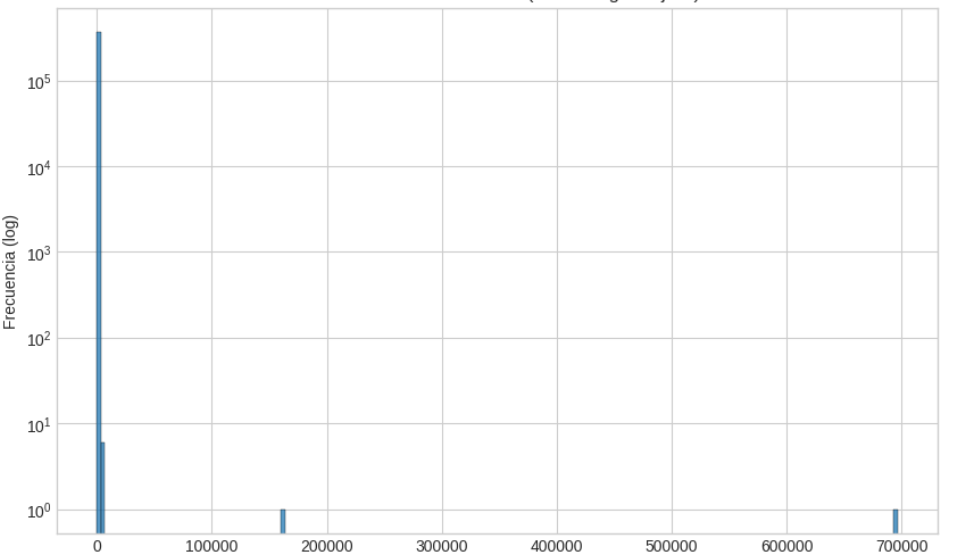

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df,
    x="buyer_d7",
    y="retention_d1_to_d7",
    estimator="mean"
)
plt.title("Media de retención (d1→d7) según buyer/no-buyer")
plt.xlabel("buyer_d7")
plt.ylabel("retention_d1_to_d7 (probabilidad media)")
plt.show()

Relación CTR/CPM percentiles con buyer rate y revenue

In [ ]:

import pandas as pd
import numpy as np

def to_float_safe(x):
    if isinstance(x, (int, float, np.number)):
        return float(x)
    try:
        return float(x)
    except:
        return np.nan

df["ctr_clean"] = df["ctr_pct_rk"].apply(to_float_safe)
df["cpm_clean"] = df["cpm_pct_rk"].apply(to_float_safe)
df["ctr_bin"] = pd.qcut(df["ctr_clean"].fillna(0), 10, labels=False, duplicates="drop")
df["cpm_bin"] = pd.qcut(df["cpm_clean"].fillna(0), 10, labels=False, duplicates="drop")
sns.lineplot(
    data=df.groupby("ctr_bin")["buyer_d7"].mean().reset_index(),
    x="ctr_bin",
    y="buyer_d7"
)
plt.title("Buyer rate según percentil CTR")
plt.show()
sns.lineplot(
    data=df.groupby("cpm_bin")["iap_revenue_d7"].mean().reset_index(),
    x="cpm_bin",
    y="iap_revenue_d7"
)
plt.title("Revenue medio según percentil CPM")
plt.show()

Diagnostico vacios

In [ ]:
print("CTR CLEAN - describe:")
print(df["ctr_clean"].describe())
print("\nValores únicos CTR clean:", df["ctr_clean"].nunique())

print("\nCPM CLEAN - describe:")
print(df["cpm_clean"].describe())
print("\nValores únicos CPM clean:", df["cpm_clean"].nunique())

Creacion features Universales

In [5]:
import numpy as np
import pandas as pd

def add_hour_features(df):
    """Adds hour cyclic features and hour groups."""
    df["hour"] = df["hour"].fillna(0).astype(int)

    # Ciclicidad
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    # Bins de hora
    df["hour_group"] = pd.cut(
        df["hour"],
        bins=[-1, 6, 12, 18, 24],
        labels=["night", "morning", "afternoon", "evening"]
    )

    # Flags rápidas
    df["is_night"] = (df["hour"] <= 6).astype(int)
    df["is_evening"] = (df["hour"] >= 18).astype(int)

    return df

Features solo Teacher: 
Target encoding por categoria

In [6]:
def target_encode(df, col, target, min_samples=200):
    """
    Performs smoothed target encoding:
    TE = (global_mean * w) + (group_mean * (1-w))
    """
    global_mean = df[target].mean()

    stats = df.groupby(col)[target].agg(['mean', 'count'])
    smoothing = 1 / (1 + np.exp(-(stats['count'] - min_samples)))
    
    stats["te"] = global_mean * (1 - smoothing) + stats["mean"] * smoothing
    return stats["te"].to_dict()

Whale likelihood by category

In [7]:
def compute_category_whale_rate(df, rev_col="iap_revenue_d7"):
    whale_threshold = df[rev_col].quantile(0.80)
    df["is_whale"] = (df[rev_col] >= whale_threshold).astype(int)

    whale_map = df.groupby("advertiser_category")["is_whale"].mean().to_dict()
    return whale_map
    

Funciones solo student

Frecuencia de país (country_freq)

In [8]:
def compute_country_freq(df):
    freq = df["country"].value_counts(normalize=True).to_dict()
    return freq

3.2. Whale rate por país

In [9]:
def compute_country_whale_rate(df, rev_col="iap_revenue_d7"):
    whale_threshold = df[rev_col].quantile(0.80)
    df["is_whale"] = (df[rev_col] >= whale_threshold).astype(int)

    country_whale = df.groupby("country")["is_whale"].mean().to_dict()
    return country_whale


Revenue promedio d7 por país

In [10]:
def compute_country_avg_rev(df, rev_col="iap_revenue_d7"):
    avg_rev = df.groupby("country")[rev_col].mean().to_dict()
    return avg_rev

In [11]:
def add_recency_features(df, now_ts_col="debug_ts"):
    ts = df[now_ts_col]

    if "last_buy_ts_bundle" in df:
        df["recency_last_buy"] = (ts - df["last_buy_ts_bundle"]).clip(lower=0)
    else:
        df["recency_last_buy"] = 0

    if "last_install_ts_bundle" in df:
        df["recency_last_install"] = (ts - df["last_install_ts_bundle"]).clip(lower=0)
    else:
        df["recency_last_install"] = 0

    if "first_request_ts" in df:
        df["recency_first_request"] = (ts - df["first_request_ts"]).clip(lower=0)
    else:
        df["recency_first_request"] = 0

    return df

In [12]:
import numpy as np
from collections import Counter

def compress_hist(feature):
    def _inner(x):
        if not isinstance(x, list):
            return pd.Series([0, 0, 0], index=[feature+"_len", feature+"_mean", feature+"_entropy"])
        cnt = Counter(x)
        values = list(cnt.values())
        total = sum(values)
        probs = np.array(values) / total
        entropy = -(probs * np.log(probs + 1e-9)).sum()
        return pd.Series([len(x), np.mean(values), entropy], 
                         index=[feature+"_len", feature+"_mean", feature+"_entropy"])
    return _inner

TEST FINAL


In [18]:


set(df_sample.columns) - set(df.columns)

{'debug_ts',
 'iap_revenue_d14',
 'iap_revenue_d28',
 'iap_revenue_d7',
 'iap_revenue_usd_bundle',
 'iap_revenue_usd_category',
 'iap_revenue_usd_category_bottom_taxonomy'}

Modelo Teacher Classifier




In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

# =========================================================
# 1. COPY THE SAMPLE DF
# =========================================================
df = df_sample.copy()

# =========================================================
# 2. BASIC PREPROCESSING
# =========================================================
# These ARE leakage — include post-install USD revenue
usd_leakage = [
    "iap_revenue_usd_bundle",
    "iap_revenue_usd_category",
    "iap_revenue_usd_category_bottom_taxonomy",
]

df.drop(columns=usd_leakage, errors="ignore", inplace=True)

# DO NOT DROP 'iap_revenue_d7', 'iap_revenue_d14', etc.

df["country"] = df["country"].fillna("UNK")
df["advertiser_category"] = df["advertiser_category"].fillna("UNK")
df["dev_os"] = df["dev_os"].fillna("UNK")

# ================================
# 2.B RECENCY FEATURES
# ================================

if "last_buy" in df.columns:
    df["recency_buy"] = (df["datetime"] - pd.to_datetime(df["last_buy"], errors="coerce")).dt.total_seconds()/86400
    df["recency_buy"] = df["recency_buy"].fillna(999)

if "last_ins" in df.columns:
    df["recency_install"] = (df["datetime"] - pd.to_datetime(df["last_ins"], errors="coerce")).dt.total_seconds()/86400
    df["recency_install"] = df["recency_install"].fillna(999)

# =========================================================
# 3. HOUR FEATURES
# =========================================================
df = add_hour_features(df)

# =========================================================
# 4. TARGET ENCODING — ONLY FOR TEACHER
# =========================================================
buyer_te_cat = target_encode(df, "advertiser_category", target="buyer_d7")
buyer_te_country = target_encode(df, "country", target="buyer_d7")

df["advertiser_category_te"] = df["advertiser_category"].map(buyer_te_cat)
df["country_te"] = df["country"].map(buyer_te_country)

# Fill missing encodings
df["advertiser_category_te"] = df["advertiser_category_te"].fillna(df["buyer_d7"].mean())
df["country_te"] = df["country_te"].fillna(df["buyer_d7"].mean())

# =========================================================
# 5. WHALE-BASED FEATURES (correlation with big spenders)
# =========================================================
whale_by_cat = compute_category_whale_rate(df, rev_col="iap_revenue_d7")
whale_by_country = compute_country_whale_rate(df, rev_col="iap_revenue_d7")
avg_rev_country = compute_country_avg_rev(df, rev_col="iap_revenue_d7")

df["cat_whale_rate"] = df["advertiser_category"].map(whale_by_cat)
df["country_whale_rate"] = df["country"].map(whale_by_country)
df["country_avg_rev"] = df["country"].map(avg_rev_country)

# Fill missing
df["cat_whale_rate"] = df["cat_whale_rate"].fillna(0)
df["country_whale_rate"] = df["country_whale_rate"].fillna(0)
df["country_avg_rev"] = df["country_avg_rev"].fillna(0)

# ================================
# 5.B INTERACTION FEATURES
# ================================

if "avg_act_days" in df.columns and "weeks_since_first_seen" in df.columns:
    df["activity_intensity"] = df["avg_act_days"] / (df["weeks_since_first_seen"] + 1)

# =========================================================
# 6. SELECT TEACHER FEATURES
# (dense + category + cyclic + encodings + whale stats)
# =========================================================
teacher_features = [
    "hour", "hour_sin", "hour_cos",
    "weekday", "avg_act_days",
    "weekend_ratio", "wifi_ratio",
    "weeks_since_first_seen",
    "recency_buy", "recency_install", "activity_intensity",
    "advertiser_category", "country", "dev_os",
    "advertiser_category_te", "country_te",
    "cat_whale_rate", "country_whale_rate", "country_avg_rev",
]


teacher_features = [f for f in teacher_features if f in df.columns]

print("USING TEACHER FEATURES:", teacher_features)

# =========================================================
# 6B. SANITY FILTER — REMOVE ANY NON-TABLE FEATURES
# =========================================================

# Mantener SOLO las columnas del modelo + label + datetime
df = df[teacher_features + ["buyer_d7", "datetime"]].copy()
teacher_features = [c for c in teacher_features if c in df.columns]
print("FINAL TEACHER FEATURES:", teacher_features)

# Comprobar SI QUEDA alguna columna inválida (listas/dicts)
bad_cols = []
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, (list, dict))).any():
        bad_cols.append(col)

if bad_cols:
    print("Dropping columns with list/dict values:", bad_cols)
    df.drop(columns=bad_cols, inplace=True)

teacher_features = [c for c in teacher_features if c in df.columns]

print("CLEANED TEACHER FEATURES:", teacher_features)

print("FINAL DF SHAPE:", df.shape)
print("FINAL COLUMNS:", df.columns.tolist())

# =========================================================
# 7. TRAIN/VAL SPLIT (temporal consistent)
# (split by datetime if available)
# =========================================================

# =========================================================
# TRAIN/VAL SPLIT (85/15)
# =========================================================

train_df = df.iloc[: int(len(df) * 0.85)]
val_df   = df.iloc[int(len(df) * 0.85):]

# Seleccionamos TODAS las columnas menos las que no son features
teacher_features = [
    c for c in df.columns 
    if c not in ["buyer_d7", "datetime"]
]

X_train = train_df[teacher_features]
y_train = train_df["buyer_d7"]

X_val = val_df[teacher_features]
y_val = val_df["buyer_d7"]

cat_cols = ["advertiser_category", "country", "dev_os"]
cat_cols = [c for c in cat_cols if c in teacher_features]

print("Train size:", X_train.shape)
print("Val size:", X_val.shape)
print("Categorical cols:", cat_cols)

USING TEACHER FEATURES: ['hour', 'hour_sin', 'hour_cos', 'weekday', 'avg_act_days', 'weekend_ratio', 'wifi_ratio', 'weeks_since_first_seen', 'recency_buy', 'recency_install', 'activity_intensity', 'advertiser_category', 'country', 'dev_os', 'advertiser_category_te', 'country_te', 'cat_whale_rate', 'country_whale_rate', 'country_avg_rev']
FINAL TEACHER FEATURES: ['hour', 'hour_sin', 'hour_cos', 'weekday', 'avg_act_days', 'weekend_ratio', 'wifi_ratio', 'weeks_since_first_seen', 'recency_buy', 'recency_install', 'activity_intensity', 'advertiser_category', 'country', 'dev_os', 'advertiser_category_te', 'country_te', 'cat_whale_rate', 'country_whale_rate', 'country_avg_rev']
CLEANED TEACHER FEATURES: ['hour', 'hour_sin', 'hour_cos', 'weekday', 'avg_act_days', 'weekend_ratio', 'wifi_ratio', 'weeks_since_first_seen', 'recency_buy', 'recency_install', 'activity_intensity', 'advertiser_category', 'country', 'dev_os', 'advertiser_category_te', 'country_te', 'cat_whale_rate', 'country_whale_rate

In [21]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, average_precision_score

# =========================================================
# 1. POOLS
# =========================================================

train_pool = Pool(
    X_train,
    y_train,
    cat_features=cat_cols
)

val_pool = Pool(
    X_val,
    y_val,
    cat_cols
)

# =========================================================
# 2. MODELO
# =========================================================

model = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.035,
    depth=8,
    l2_leaf_reg=6,
    random_strength=1.8,
    loss_function="Logloss",
    eval_metric="AUC",
    bootstrap_type="Bernoulli",
    subsample=0.75,
    rsm=0.9,
    leaf_estimation_iterations=4,
    border_count=254,
    one_hot_max_size=100,
    task_type="CPU",
    verbose=100,
    od_type="Iter",
    od_wait=100   
)

# =========================================================
# 3. TRAIN
# =========================================================

model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)

# =========================================================
# 4. METRICAS
# =========================================================

val_preds = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, val_preds)
pr_auc = average_precision_score(y_val, val_preds)

print("\n===== VALIDATION METRICS =====")
print("AUC:", auc)
print("PR-AUC:", pr_auc)

0:	test: 0.6923449	best: 0.6923449 (0)	total: 840ms	remaining: 16m 47s
100:	test: 0.8429666	best: 0.8429666 (100)	total: 1m 17s	remaining: 14m 8s
200:	test: 0.8496309	best: 0.8496309 (200)	total: 2m 28s	remaining: 12m 20s
300:	test: 0.8534664	best: 0.8534664 (300)	total: 3m 39s	remaining: 10m 54s
400:	test: 0.8554705	best: 0.8554705 (400)	total: 4m 49s	remaining: 9m 37s
500:	test: 0.8571118	best: 0.8571118 (500)	total: 6m	remaining: 8m 23s
600:	test: 0.8583170	best: 0.8583246 (599)	total: 7m 12s	remaining: 7m 11s
700:	test: 0.8590756	best: 0.8590756 (700)	total: 8m 25s	remaining: 5m 59s
800:	test: 0.8595225	best: 0.8595307 (798)	total: 9m 36s	remaining: 4m 47s
900:	test: 0.8600954	best: 0.8600954 (900)	total: 10m 49s	remaining: 3m 35s
1000:	test: 0.8605708	best: 0.8605708 (1000)	total: 12m 2s	remaining: 2m 23s
1100:	test: 0.8611209	best: 0.8611209 (1100)	total: 13m 13s	remaining: 1m 11s
1199:	test: 0.8615067	best: 0.8615067 (1199)	total: 14m 24s	remaining: 0us

bestTest = 0.8615066694


TEACHER REGRESSOR

In [39]:
# =========================================================
# TEACHER REGRESSOR (LightGBM) PARA iap_revenue_d7
# =========================================================
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error

# 0) PARTIMOS DE df_sample (ya cargado antes)
df_reg = df_sample.copy()

print("df_reg shape inicial:", df_reg.shape)

# ---------------------------------------------------------
# 1) FILTRAR SOLO BUYERS (buyer_d7 == 1)
# ---------------------------------------------------------
df_reg = df_reg[df_reg["buyer_d7"] == 1].copy()
print("Solo buyers (buyer_d7 == 1):", df_reg.shape)

# Asegurar que el target existe
assert "iap_revenue_d7" in df_reg.columns, "Falta iap_revenue_d7 en df_reg"

# Opcional: quitar buyers con revenue negativo o NaN (por seguridad)
df_reg = df_reg[df_reg["iap_revenue_d7"].notna()]
df_reg = df_reg[df_reg["iap_revenue_d7"] >= 0]

print("Buyers con revenue válido:", df_reg.shape)

# ---------------------------------------------------------
# 2) ASEGURAR CAMPO datetime (ya lo generaste antes)
#    Si no está, se podría reconstruir desde el path, pero asumimos que existe.
# ---------------------------------------------------------
if "datetime" not in df_reg.columns:
    raise ValueError("df_reg no tiene columna 'datetime'. Ejecuta antes la celda que la crea.")

# Orden temporal
df_reg = df_reg.sort_values("datetime").reset_index(drop=True)

# ---------------------------------------------------------
# 3) PREPROCESADO BÁSICO DE CATEGÓRICAS
# ---------------------------------------------------------
for col in ["country", "advertiser_category", "dev_os"]:
    if col in df_reg.columns:
        df_reg[col] = df_reg[col].fillna("UNK").astype(str)

# ---------------------------------------------------------
# 4) FEATURE ENGINEERING: HORA + TARGET ENCODING + WHALE STATS
# ---------------------------------------------------------

# 4.1 Hora: hour_sin, hour_cos, hour_group, is_night, is_evening
df_reg = add_hour_features(df_reg)

# =========================================================
# EXTRA FEATURES: FIX CTR/CPM + DEVICE OS VERSION
# =========================================================

import numpy as np

def to_float_safe(x):
    """Convierte strings o listas raras en float si es posible, si no NaN."""
    if isinstance(x, (int, float, np.integer, np.floating)):
        return float(x)
    try:
        return float(x)
    except:
        return np.nan

# ----- Reparar CTR / CPM -----
if "ctr" in df.columns:
    df["ctr_clean"] = df["ctr"].apply(to_float_safe)
else:
    df["ctr_clean"] = np.nan

if "ctr_pct_rk" in df.columns:
    df["ctr_pct_rk_clean"] = df["ctr_pct_rk"].apply(to_float_safe)
else:
    df["ctr_pct_rk_clean"] = np.nan

if "cpm" in df.columns:
    df["cpm_clean"] = df["cpm"].apply(to_float_safe)
else:
    df["cpm_clean"] = np.nan

if "cpm_pct_rk" in df.columns:
    df["cpm_pct_rk_clean"] = df["cpm_pct_rk"].apply(to_float_safe)
else:
    df["cpm_pct_rk_clean"] = np.nan

df["ctr_clean"] = df["ctr_clean"].fillna(0)
df["ctr_pct_rk_clean"] = df["ctr_pct_rk_clean"].fillna(0)
df["cpm_clean"] = df["cpm_clean"].fillna(0)
df["cpm_pct_rk_clean"] = df["cpm_pct_rk_clean"].fillna(0)

# Bins
df["ctr_bin"] = pd.qcut(df["ctr_pct_rk_clean"], q=10, labels=False, duplicates="drop")
df["cpm_bin"] = pd.qcut(df["cpm_pct_rk_clean"], q=10, labels=False, duplicates="drop")
df["ctr_bin"] = df["ctr_bin"].fillna(0).astype(int)
df["cpm_bin"] = df["cpm_bin"].fillna(0).astype(int)

# =========================================================
# OS MAJOR VERSION
# =========================================================

def extract_os_major(x):
    if isinstance(x, str):
        try:
            return int(x.split(".")[0])
        except:
            return -1
    return -1

if "dev_osv" in df.columns:
    df["dev_osv_major"] = df["dev_osv"].apply(extract_os_major)
else:
    df["dev_osv_major"] = -1

# 4.2 Target encoding basado en probabilidad de ser buyer (buyer_d7)
#     Aunque aquí ya filtramos a buyers, usamos el full df_sample
#     para que las medias estén bien definidas
buyer_te_cat = target_encode(df_sample, "advertiser_category", target="buyer_d7")
buyer_te_country = target_encode(df_sample, "country", target="buyer_d7")

df_reg["advertiser_category_te"] = df_reg["advertiser_category"].map(buyer_te_cat)
df_reg["country_te"] = df_reg["country"].map(buyer_te_country)

# Rellenar fallos de mapeo con media global de buyer_d7
global_buyer_mean = df_sample["buyer_d7"].mean()
df_reg["advertiser_category_te"] = df_reg["advertiser_category_te"].fillna(global_buyer_mean)
df_reg["country_te"] = df_reg["country_te"].fillna(global_buyer_mean)

# 4.3 WHALE STATS sobre revenue d7 (solo buyers)
whale_by_cat = compute_category_whale_rate(df_reg, rev_col="iap_revenue_d7")
whale_by_country = compute_country_whale_rate(df_reg, rev_col="iap_revenue_d7")
avg_rev_country = compute_country_avg_rev(df_reg, rev_col="iap_revenue_d7")

df_reg["cat_whale_rate"] = df_reg["advertiser_category"].map(whale_by_cat)
df_reg["country_whale_rate"] = df_reg["country"].map(whale_by_country)
df_reg["country_avg_rev"] = df_reg["country"].map(avg_rev_country)

df_reg["cat_whale_rate"] = df_reg["cat_whale_rate"].fillna(0)
df_reg["country_whale_rate"] = df_reg["country_whale_rate"].fillna(0)
df_reg["country_avg_rev"] = df_reg["country_avg_rev"].fillna(0)

# ---------------------------------------------------------
# 5) DEFINIR FEATURES DEL TEACHER REGRESSOR
# ---------------------------------------------------------
teacher_reg_features = [
    "hour", "hour_sin", "hour_cos",
    "weekday", "avg_act_days",
    "weekend_ratio", "wifi_ratio",
    "weeks_since_first_seen",

    "advertiser_category", "country", "dev_os",

    "advertiser_category_te", "country_te",
    "cat_whale_rate", "country_whale_rate", "country_avg_rev",

    "buy_d7",

    # === NUEVAS FEATURES AÑADIDAS ===
    "ctr_clean", "ctr_pct_rk_clean",
    "cpm_clean", "cpm_pct_rk_clean",
    "ctr_bin", "cpm_bin",
    "dev_osv_major"
]

# Nos quedamos solo con las que existan
teacher_features_reg = [c for c in teacher_features_reg if c in df_reg.columns]
print("TEACHER REG FEATURES:", teacher_features_reg)

# ---------------------------------------------------------
# 6) ELIMINAR FEATURES TIPO LIST/DIC (no válidas para LGBM)
# ---------------------------------------------------------
bad_cols_reg = []
for col in teacher_features_reg:
    if df_reg[col].apply(lambda x: isinstance(x, (list, dict))).any():
        bad_cols_reg.append(col)

if bad_cols_reg:
    print("Eliminando columnas no tabulares (list/dict):", bad_cols_reg)
    teacher_features_reg = [c for c in teacher_features_reg if c not in bad_cols_reg]

print("FINAL REG FEATURES:", teacher_features_reg)

# Nos aseguramos de quedarnos solo con features + target + datetime
df_reg = df_reg[teacher_features_reg + ["iap_revenue_d7", "datetime"]].copy()
print("df_reg final shape:", df_reg.shape)

# ---------------------------------------------------------
# 7) TRAIN/VAL SPLIT TEMPORAL
# ---------------------------------------------------------
cut = int(len(df_reg) * 0.85)
train_df = df_reg.iloc[:cut].copy()
val_df   = df_reg.iloc[cut:].copy()

print("Train shape:", train_df.shape, "Val shape:", val_df.shape)

# ---------------------------------------------------------
# 8) OVERSAMPLING DE WHALES (solo en TRAIN)
# ---------------------------------------------------------
# Definimos whales como top 20% de revenue en el TRAIN
whale_threshold = train_df["iap_revenue_d7"].quantile(0.80)
train_df["is_whale"] = (train_df["iap_revenue_d7"] >= whale_threshold).astype(int)

whales = train_df[train_df["is_whale"] == 1]
non_whales = train_df[train_df["is_whale"] == 0]

print("Whales en train:", len(whales), "Non-whales:", len(non_whales))

# Factor de oversampling (ajustable)
oversample_factor = 4  # por ejemplo, repetimos 4 veces los whales
whales_oversampled = pd.concat([whales] * oversample_factor, ignore_index=True)

train_oversampled = pd.concat([non_whales, whales_oversampled], ignore_index=True)
train_oversampled = train_oversampled.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Train tras oversampling:", train_oversampled.shape)

# ---------------------------------------------------------
# 9) TARGET TRANSFORM: log1p
# ---------------------------------------------------------
# Clip superior para evitar que 1 whale extremo rompa la loss
upper_clip = train_oversampled["iap_revenue_d7"].quantile(0.999)
train_oversampled["rev_d7_clipped"] = train_oversampled["iap_revenue_d7"].clip(0, upper_clip)
val_df["rev_d7_clipped"] = val_df["iap_revenue_d7"].clip(0, upper_clip)

y_train = np.log1p(train_oversampled["rev_d7_clipped"].values)
y_val   = np.log1p(val_df["rev_d7_clipped"].values)

X_train = train_oversampled[teacher_features_reg].copy()
X_val   = val_df[teacher_features_reg].copy()

# ---------------------------------------------------------
# 10) CATEGÓRICAS A CATEGORY PARA LGBM
# ---------------------------------------------------------
cat_cols_reg = [c for c in ["advertiser_category", "country", "dev_os"] if c in teacher_features_reg]

for c in cat_cols_reg:
    X_train[c] = X_train[c].astype("category")
    X_val[c]   = X_val[c].astype("category")

print("Columnas categóricas para LGBM:", cat_cols_reg)

# ---------------------------------------------------------
# 11) ENTRENAR LIGHTGBM REGRESSOR (TEACHER)
# ---------------------------------------------------------
reg_params = {
    "objective": "regression_l2",
    "n_estimators": 5000,
    "learning_rate": 0.03,
    "num_leaves": 64,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 1.0,
    "reg_lambda": 1.0,
    "random_state": 42,
    "n_jobs": -1
}

reg_teacher = LGBMRegressor(**reg_params)

reg_teacher.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[],
)

cat_cols_reg = ["advertiser_category", "country", "dev_os"]
cat_cols_reg = [c for c in cat_cols_reg if c in X_train.columns]

teacher_cats = {
    col: X_train[col].astype(str).astype("category").cat.categories.tolist()
    for col in cat_cols_reg
}

print("Categorías guardadas para el regressor teacher:")
for k,v in teacher_cats.items():
    print(k, "→", len(v), "categorías")

# ---------------------------------------------------------
# 12) MÉTRICAS EN VALIDACIÓN (MSLE APROX.)
# ---------------------------------------------------------
# Predicción en escala log
y_val_pred_log = reg_teacher.predict(X_val)

# Volvemos a escala original
y_val_true = val_df["iap_revenue_d7"].values
y_val_pred = np.expm1(y_val_pred_log)

# Para MSLE necesitamos clip a >= 0
y_val_true_clip = np.clip(y_val_true, 0, None)
y_val_pred_clip = np.clip(y_val_pred, 0, None)

msle = mean_squared_log_error(y_val_true_clip, y_val_pred_clip)
rmse_log = np.sqrt(mean_squared_error(y_val, y_val_pred_log))

print("\n===== MÉTRICAS TEACHER REGRESSOR (VALIDACIÓN) =====")
print(f"RMSE en log1p(revenue_d7): {rmse_log:.5f}")
print(f"MSLE aproximado en escala original: {msle:.6f}")

# Opcional: inspeccionar importancia de variables
importances = pd.Series(reg_teacher.feature_importances_, index=teacher_features_reg).sort_values(ascending=False)
print("\nTOP 15 FEATURES:")
print(importances.head(15))


df_reg shape inicial: (2175981, 85)
Solo buyers (buyer_d7 == 1): (71758, 85)
Buyers con revenue válido: (71758, 85)
TEACHER REG FEATURES: ['hour', 'hour_sin', 'hour_cos', 'weekday', 'avg_act_days', 'weekend_ratio', 'wifi_ratio', 'weeks_since_first_seen', 'advertiser_category', 'country', 'dev_os', 'advertiser_category_te', 'country_te', 'cat_whale_rate', 'country_whale_rate', 'country_avg_rev', 'buy_d7']
FINAL REG FEATURES: ['hour', 'hour_sin', 'hour_cos', 'weekday', 'avg_act_days', 'weekend_ratio', 'wifi_ratio', 'weeks_since_first_seen', 'advertiser_category', 'country', 'dev_os', 'advertiser_category_te', 'country_te', 'cat_whale_rate', 'country_whale_rate', 'country_avg_rev', 'buy_d7']
df_reg final shape: (71758, 19)
Train shape: (60994, 19) Val shape: (10764, 19)
Whales en train: 12275 Non-whales: 48719
Train tras oversampling: (97819, 20)
Columnas categóricas para LGBM: ['advertiser_category', 'country', 'dev_os']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

In [28]:
import pandas as pd

def align_categories(df_student, teacher_cats):
    """
    Alinea las categorías de df_student con las usadas por el teacher (LightGBM).
    teacher_cats: dict {col: [lista_de_categorias_del_teacher]}
    """
    df_aligned = df_student.copy()
    
    for col, cats in teacher_cats.items():
        if col not in df_aligned.columns:
            continue

        # Pasar a string y meter token para missing
        s = df_aligned[col].astype(str)
        s = s.where(df_aligned[col].notna(), "__MISSING__")

        # Crear Categorical con EXACTAMENTE las categorías del teacher
        df_aligned[col] = pd.Categorical(s, categories=cats)

    return df_aligned

Distillation

In [19]:
for name, val in globals().items():
    if "catboost" in str(type(val)).lower():
        print("Encontrado CATBOOST teacher ->", name)

for name, val in globals().items():
    if "lgbm" in str(type(val)).lower() or "lightgbm" in str(type(val)).lower():
        print("Encontrado LGBM teacher ->", name)

Encontrado LGBM teacher -> reg_teacher


In [40]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

print("=== PRODUCIENDO PREDICCIONES SIMPLIFICADAS ===")

# =======================================
# 1. Clasificador → Probabilidad de buyer
# =======================================

X_clf = df[teacher_features].copy()
p_buy = clf_teacher.predict_proba(X_clf)[:, 1]

print("Preview P(buyer):", p_buy[:5])


# =======================================
# 2. Regresor → Revenue dado que es buyer
# (NO HAY CATEGORÍAS AQUÍ → NO PUEDE FALLAR)
# =======================================

X_reg = df[reg_features].copy()
rev_log = reg_teacher.predict(X_reg)
rev_pred = np.expm1(rev_log)

# evitar NaN / inf
rev_pred = np.nan_to_num(rev_pred, nan=0.0, posinf=2000, neginf=0.0)

print("Preview Revenue_pred:", rev_pred[:5])


# =======================================
# 3. Pred final = P(buyer) × revenue_pred
# =======================================

final_pred = p_buy * rev_pred
final_pred = np.clip(final_pred, 0, None)   # MSLE requiere >=0

print("Preview Final pred:", final_pred[:5])


# =======================================
# 4. MSLE oficial
# =======================================

y_true = df["iap_revenue_d7"].clip(0).values

msle = mean_squared_log_error(y_true, final_pred)
rmsle = msle ** 0.5

print("\n========================")
print("FINAL MSLE :", msle)
print("FINAL RMSLE:", rmsle)
print("========================")

=== PRODUCIENDO PREDICCIONES SIMPLIFICADAS ===
Preview P(buyer): [0.00849606 0.03817421 0.09636175 0.00355538 0.00339852]


ValueError: train and valid dataset categorical_feature do not match.

In [29]:
import numpy as np
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

clf_teacher = model      # CatBoost classifier
reg_teacher = reg_teacher  # LightGBM regressor

reg_features = [
    "hour", "hour_sin", "hour_cos",
    "weekday", "avg_act_days",
    "weekend_ratio", "wifi_ratio",
    "weeks_since_first_seen",
    "advertiser_category", "country", "dev_os",
    "advertiser_category_te", "country_te",
    "cat_whale_rate", "country_whale_rate", "country_avg_rev",
    "buy_d7"
]
reg_features = [c for c in reg_features if c in df.columns]
# ==============================================
# 1. PREDICCIONES DEL TEACHER SOBRE TODO DF
# ==============================================

# Aseguramos orden temporal consistente
df_student = df.sort_values("datetime").reset_index(drop=True).copy()

# --- Probas de comprador del teacher (CatBoost) ---
X_teacher = df_student[teacher_features]
p_teacher_buy = clf_teacher.predict_proba(X_teacher)[:, 1]

df_student["p_teacher_buy"] = p_teacher_buy

# =========================================================
# ALINEAR CATEGORÍAS DEL STUDENT CON EL TEACHER REGRESSOR
# =========================================================
df_student = align_categories(df_student, teacher_cats)

# Y recreamos X_reg_all ya alineado
X_reg_all = df_student[reg_features]

# --- Predicción de revenue del teacher (LightGBM) ---
X_reg_all = df_student[reg_features]
rev_teacher_log = reg_teacher.predict(X_reg_all)

# Clampeamos para evitar locuras numéricas
rev_teacher_log = np.clip(rev_teacher_log, 0, None)

# Revenue esperado "suavizado":
rev_teacher = np.expm1(rev_teacher_log)   # back-transform de log1p
rev_teacher_expected = rev_teacher * p_teacher_buy

df_student["rev_teacher_expected"] = rev_teacher_expected

print("df_student shape:", df_student.shape)
print(df_student[["p_teacher_buy", "rev_teacher_expected"]].describe())

[LightGBM] [Fatal] The number of features in data (16) is not the same as it was in training data (17).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (16) is not the same as it was in training data (17).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

Features del student

In [ ]:
# ==============================================
# 2. FEATURES DEL STUDENT
# ==============================================

student_features = [
    "hour", "hour_sin", "hour_cos",
    "weekday", "avg_act_days",
    "weekend_ratio", "wifi_ratio",
    "weeks_since_first_seen",
    "advertiser_category", "country", "dev_os",
    "cat_whale_rate", "country_whale_rate", "country_avg_rev"
]

student_features = [c for c in student_features if c in df_student.columns]
cat_cols_student = [c for c in ["advertiser_category", "country", "dev_os"]
                    if c in student_features]

print("STUDENT FEATURES:", student_features)
print("STUDENT CAT COLS:", cat_cols_student)

Train-val split

In [ ]:
# ==============================================
# 3. TRAIN / VAL SPLIT
# ==============================================

split_idx = int(len(df_student) * 0.85)
train_s = df_student.iloc[:split_idx]
val_s   = df_student.iloc[split_idx:]

X_train_s = train_s[student_features]
X_val_s   = val_s[student_features]

# Targets de distillation
y_train_clf = train_s["p_teacher_buy"]
y_val_clf   = val_s["p_teacher_buy"]

y_train_reg = train_s["rev_teacher_expected"]
y_val_reg   = val_s["rev_teacher_expected"]

print("Train student:", X_train_s.shape, "Val student:", X_val_s.shape)


Student classifier (LightGBM) — distilling el CatBoost

In [ ]:
# ==============================================
# 4. STUDENT CLASSIFIER (LGBM)
#    objetivo: imitar p_teacher_buy
# ==============================================

student_clf = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    n_jobs=-1
)

student_clf.fit(
    X_train_s,
    y_train_clf,   # soft labels en [0,1]
    eval_set=[(X_val_s, y_val_clf)],
    eval_metric="logloss",
    verbose=50,
    categorical_feature=cat_cols_student
)

# Evaluación rápida: ¿qué tal imita al teacher?
p_student_val = student_clf.predict_proba(X_val_s)[:, 1]
mse_clf = mean_squared_error(y_val_clf, p_student_val)
print("\n===== STUDENT CLASSIFIER =====")
print("MSE vs teacher probs:", mse_clf)

# Si quieres AUC vs label real (por curiosidad)
if "buyer_d7" in df_student.columns:
    y_val_true = val_s["buyer_d7"]
    auc_student = roc_auc_score(y_val_true, p_student_val)
    print("AUC vs label real buyer_d7:", auc_student)

Student regressor (LightGBM) — distilling el teacher regressor

In [ ]:
# ==============================================
# 5. STUDENT REGRESSOR (LGBM)
#    objetivo: imitar rev_teacher_expected
# ==============================================

student_reg = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="regression",
    n_jobs=-1
)

student_reg.fit(
    X_train_s,
    y_train_reg,
    eval_set=[(X_val_s, y_val_reg)],
    eval_metric="rmse",
    verbose=50,
    categorical_feature=cat_cols_student
)

rev_student_val = student_reg.predict(X_val_s)
rmse_student = mean_squared_error(y_val_reg, rev_student_val, squared=False)

print("\n===== STUDENT REGRESSOR =====")
print("RMSE vs teacher expected revenue:", rmse_student)